---

title: Distance based sampling (Jaccard Distance)

author: Tiago Ribeiro

date: 04/05/2023

---


In [1]:
from watermark import watermark
print(watermark(author="\033[1m" +"Tiago F. R. Ribeiro" + "\033[0m", 
                github_username="\033[1m" +"Tiago1Ribeiro"+ "\033[0m", 
                current_date=True, current_time=True, python=True, updated=True,
                iversions=True,  globals_= globals()))

Author: Tiago F. R. Ribeiro

Github username: Tiago1Ribeiro

Last updated: 2023-04-04 12:39:32

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.11.0



In [2]:
import os
from glob import glob
from shapely.wkt import loads

#### Data Sources

In [16]:
SEGS_POL_FILE = "E://BurnedAreaUAV_files//Results//WKT_files//segs_unet_base.wkt"
SEGS_TRAIN_FILE = "E://BurnedAreaUAV_files//BurnedAreaUAV_dataset//WKT_files//train_valid.wkt"
SAMPLED_SEGS = "E://BurnedAreaUAV_files//Interpolation//reference_masks//sampled_masks.txt"
SAMPLED_SEGS_WKT = "E://BurnedAreaUAV_files//Interpolation//reference_masks//sampled_masks.wkt"

with open(SEGS_TRAIN_FILE, 'r') as wkt_file:
    # list of polygons
    multipolygons = wkt_file.readlines()
# convert multipolygons to shapely polygons
sh_polygons = list()
for multipolygon in multipolygons:
    sh_polygon = loads(multipolygon)
    sh_polygons.append(sh_polygon)


### Functions

#### calculate_distances

In [48]:
from scipy.spatial.distance import jaccard
import numpy as np
from tqdm import tqdm
from rasterio.features import rasterize

def calculate_distances(polygons, out_shape = (720, 1280)):
    """
    Calculates the Jaccard distance between binary segmentation masks of the 
    first and subsequent polygons

    Args:
        polygons (list): A list of polygons represented as a list of coordinate 
        tuples.
        out_shape (tuple): The shape of the output rasterized mask. 
        Default is (720, 1280).

    Returns:
        dict: A dictionary with two keys - "Jaccard distance". The values
        for each key are lists containing the distance values between the 
        first and subsequent polygons

    """
    distances = {"Jaccard distance":[]}
    mask_t0 = rasterize([polygons[0]], out_shape)
    coord_t0 = np.argwhere(mask_t0)

    # Convert each polygon to a binary mask and calculate distances
    for i in range(1, len(polygons)):
        mask_tn = rasterize([polygons[i]], out_shape)
        jaccard_distance = jaccard(mask_t0.flatten(), mask_tn.flatten())
        distances["Jaccard distance"].append(jaccard_distance)
        print(f"{i}/{len(polygons)-1}: Jaccard distance: {jaccard_distance:.4f} ", end="\r")
    return distances

In [49]:
distances = calculate_distances(sh_polygons)

#### plot_polygons_as_images

In [56]:
def plot_polygons_as_images(distances, polygons, image_size=(720, 1280)):
    # counts number of polygons
    num_polygons = len(distances['index'])
    # print('num_polygons:', num_polygons)
    # calculate number of rows and columns in the grid
    num_cols = 3
    num_rows = int(np.ceil(num_polygons / num_cols))
    # print('num. of graphs:', num_rows*num_cols)
    
    # create a new figure with the desired size
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, num_rows*4))
    axes = axes.flatten()  
    
    # loop over the polygons and plot them as images on the grid
    i = 0
    for idx in distances['index']:
        ax = axes[i]
        img = rasterio.features.rasterize([polygons[idx]], out_shape=image_size)
        ax.imshow(img)
        ax.set_title(f"Frame #{idx}")
        i += 1
    
    # adjust the layout to make sure all images are visible
    fig.tight_layout()
    
    # show the plot
    plt.show()

#### sample_polygons

In [1]:
def sample_polygons_v2(polygons, threshold=0.15, out_shape = (720, 1280)):
    """
    Generate a set of samples from a list of polygons based on their similarity.

    Args:
        polygons (list): A list of polygons represented as lists of (x, y) tuples.
        threshold (float): The Jaccard distance threshold for creating a new sample.
            Defaults to 0.15.
        out_shape (tuple): The output shape of the rasterized polygons.
            Defaults to (720, 1280).

    Returns:
        dict: A dictionary with two keys: "index" and "Jaccard distance".
            The "index" value is the index of the polygon in the input list 
            for each sample.

    """
    # instantiate dictionary to store index and distance values
    samples = {"index": [0], "Jaccard distance":[0.0]}
    jaccard_distance = 0.0
    idx = 0
    while idx < len(polygons)-1:
        mask_n = rasterize([polygons[idx]], out_shape)
        jaccard_distance = 0.0
        while jaccard_distance < threshold and idx < len(polygons)-1:
            idx += 1
            mask_m = rasterize([polygons[idx]], out_shape)
            jaccard_distance = jaccard(mask_n.flatten(), mask_m.flatten())
            
        # append index and distance to dictionary
        samples["index"].append(idx)
        samples["Jaccard distance"].append(jaccard_distance)
        print(f"index: {idx}, Jaccard distance: {jaccard_distance:.4f}")
    print(f"Number of resulting samples: {len(samples['index'])}")

    return samples

In [8]:
threshold = 0.15
samples = sample_polygons_v2(sh_polygons, threshold=threshold)

index: 19, Jaccard distance: 0.1590
index: 28, Jaccard distance: 0.1528
index: 48, Jaccard distance: 0.1830
index: 56, Jaccard distance: 0.1570
index: 74, Jaccard distance: 0.1745
index: 82, Jaccard distance: 0.1522
index: 87, Jaccard distance: 0.1598
index: 106, Jaccard distance: 0.1684
index: 128, Jaccard distance: 0.1717
index: 173, Jaccard distance: 0.1501
index: 195, Jaccard distance: 0.1529
index: 225, Jaccard distance: 0.1120
Number of resulting samples: 13


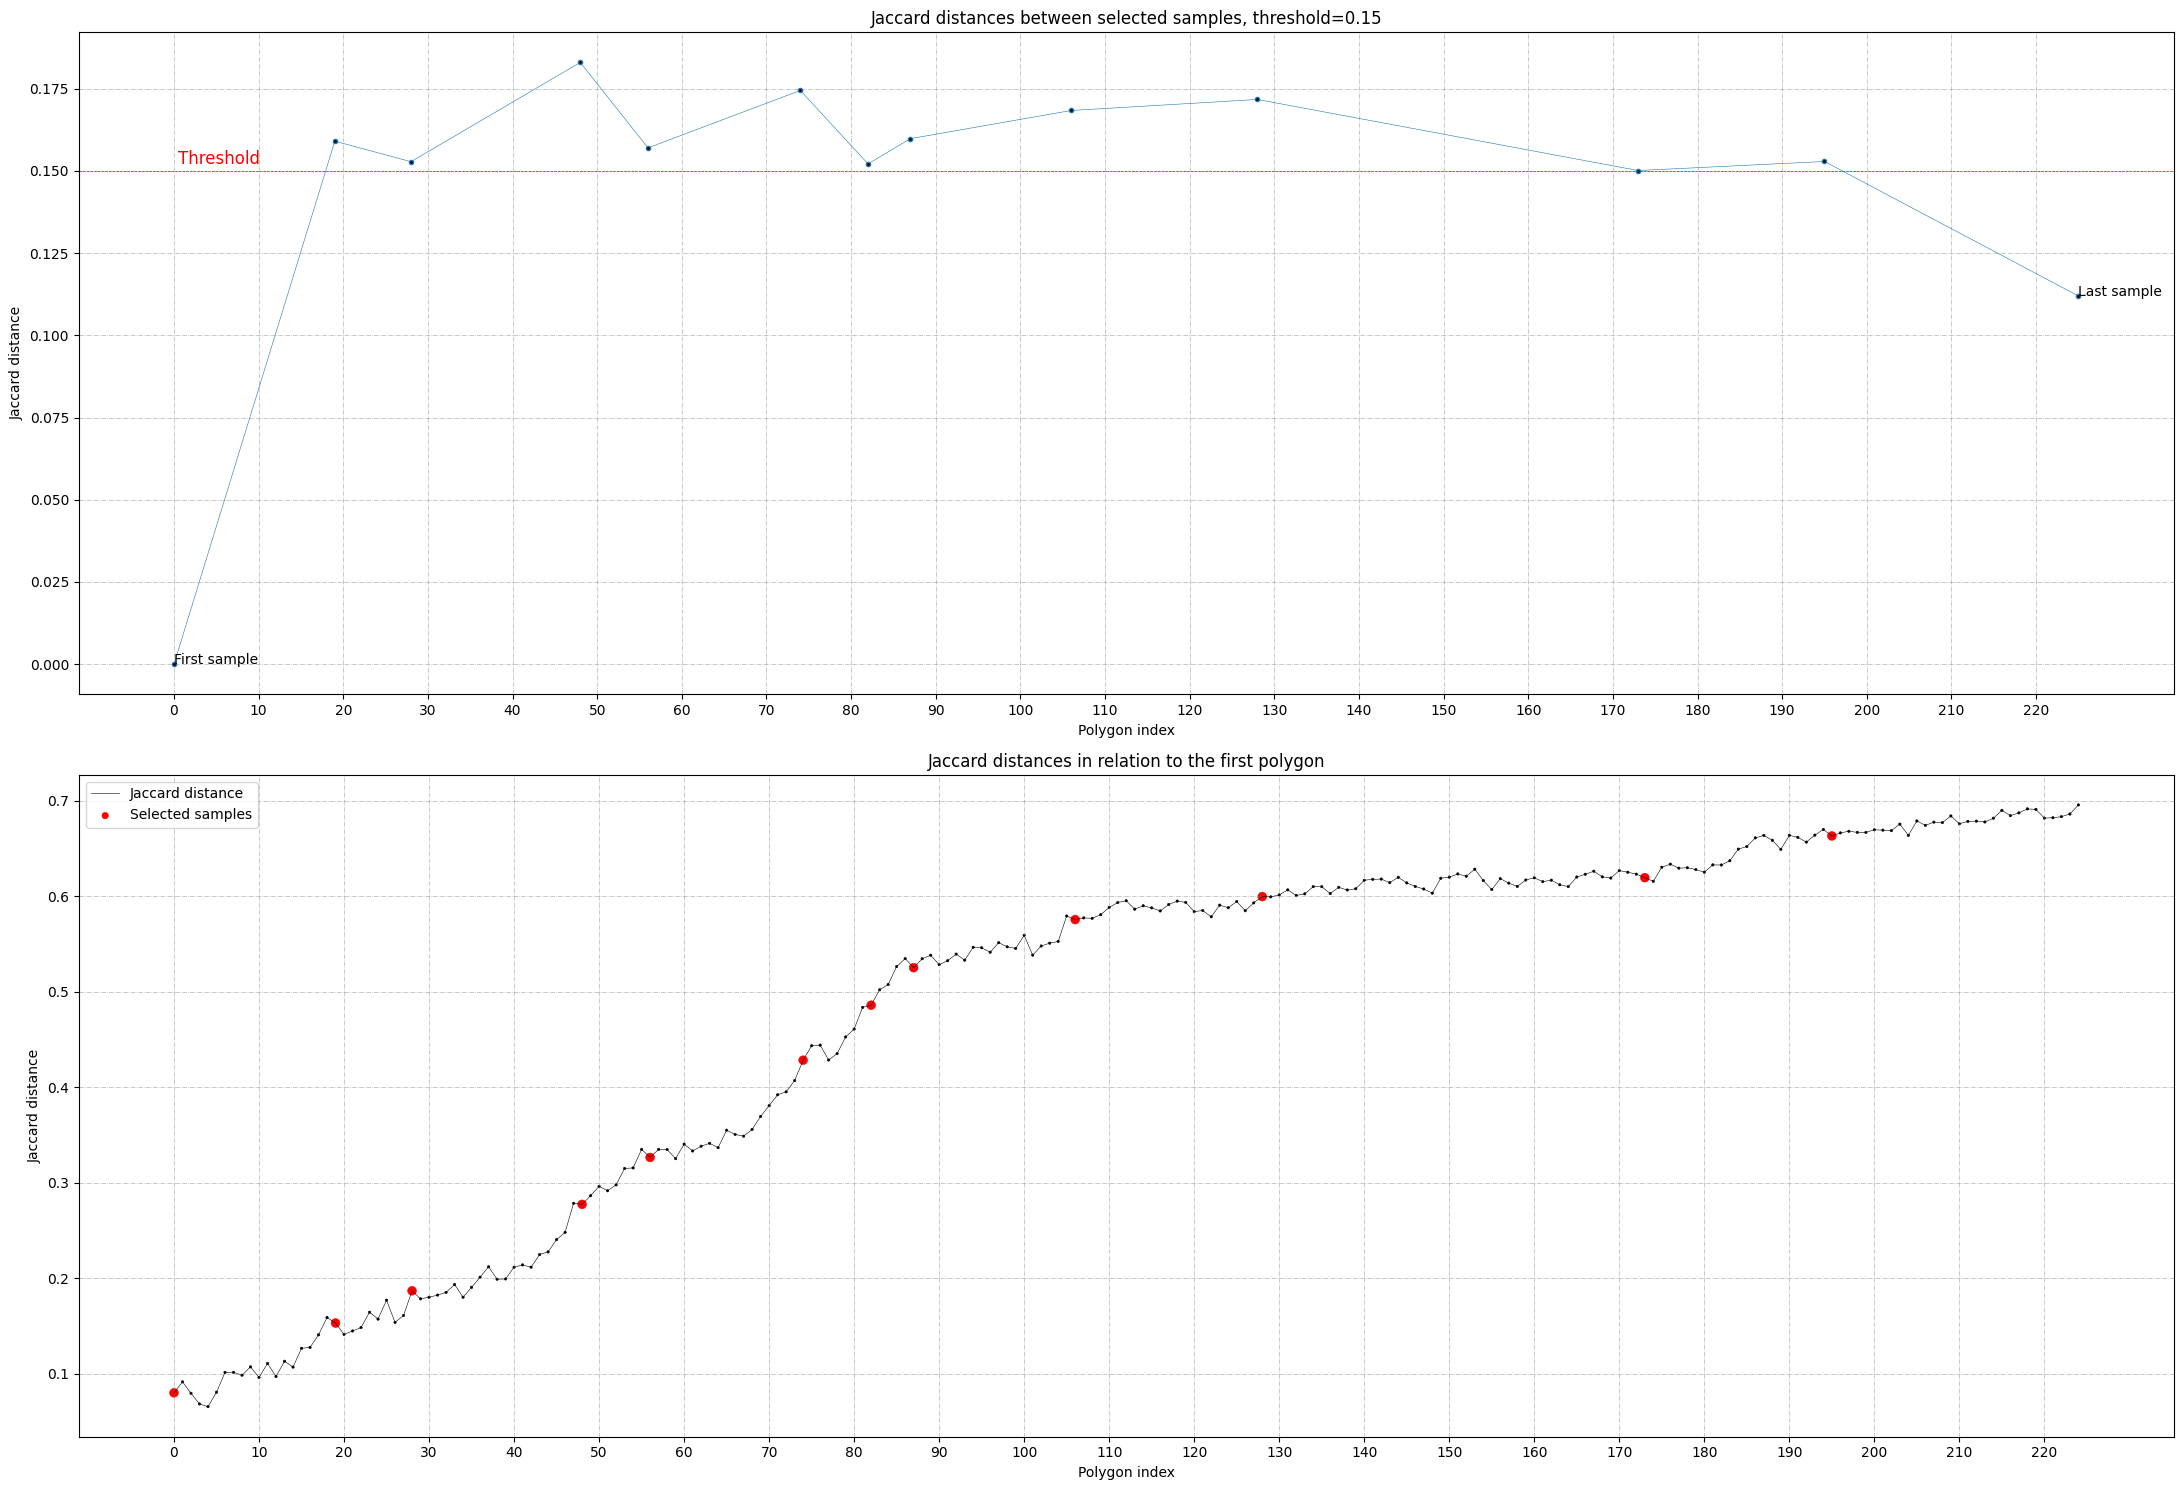

In [55]:
import matplotlib.pyplot as plt

# create two subplots side by side
fig, axs = plt.subplots(2, 1, figsize=(22, 15))

# plot the distances for the first subplot
axs[0].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.6)
axs[0].set_xticks(range(0, len(distances["Jaccard distance"]), 10))
axs[0].plot(samples["index"], samples["Jaccard distance"], marker='o', markersize=3,
            markerfacecolor='black', linewidth=0.4)
axs[0].set_xlabel("Polygon index")
axs[0].set_ylabel("Jaccard distance")
axs[0].set_title("Jaccard distances from the selected samples, threshold=0.15")
# add a threshold line with a label
axs[0].axhline(y=threshold, color='r', linestyle='--', linewidth=0.5)
axs[0].text(0.5, threshold+0.002, "Threshold", color='r', fontsize=12)
# add a text annotation to the first and last sample
axs[0].annotate("First sample", xy=(0, 0), xytext=(0, 0.0), fontsize=10)
axs[0].annotate("Last sample", xy=(samples["index"][-1], 0), 
                xytext=(samples["index"][-1], samples["Jaccard distance"][-1]), 
                fontsize=10)

# plot the distances for the second subplot
axs[1].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.6)
# xticks 
axs[1].set_xticks(range(0, len(distances["Jaccard distance"]), 10))

axs[1].plot(range(len(distances["Jaccard distance"])), distances["Jaccard distance"],
            c='black', linewidth=0.4) 

# size = [40 if i in samples["index"]  else 3 for i in range(len(distances["Jaccard distance"])+1)]             
axs[1].scatter(range(len(distances["Jaccard distance"])), 
               distances["Jaccard distance"],
               s=[40 if i in samples["index"]  else 3 for i in range(len(distances["Jaccard distance"])+1)],
               c=["red" if i in samples["index"] else 'black' for i in range(len(distances["Jaccard distance"])+1)],
               marker='o', facecolor='black', linewidth=0.4)
# plot line plot to connect the dots
axs[1].set_xlabel("Polygon index")
axs[1].set_ylabel("Jaccard distance")
axs[1].set_title("Jaccard distances in relation to the first polygon")
# add a legend for the highlighted samples
axs[1].legend(["Jaccard distance", "Selected samples"])

plt.tight_layout()
plt.show()

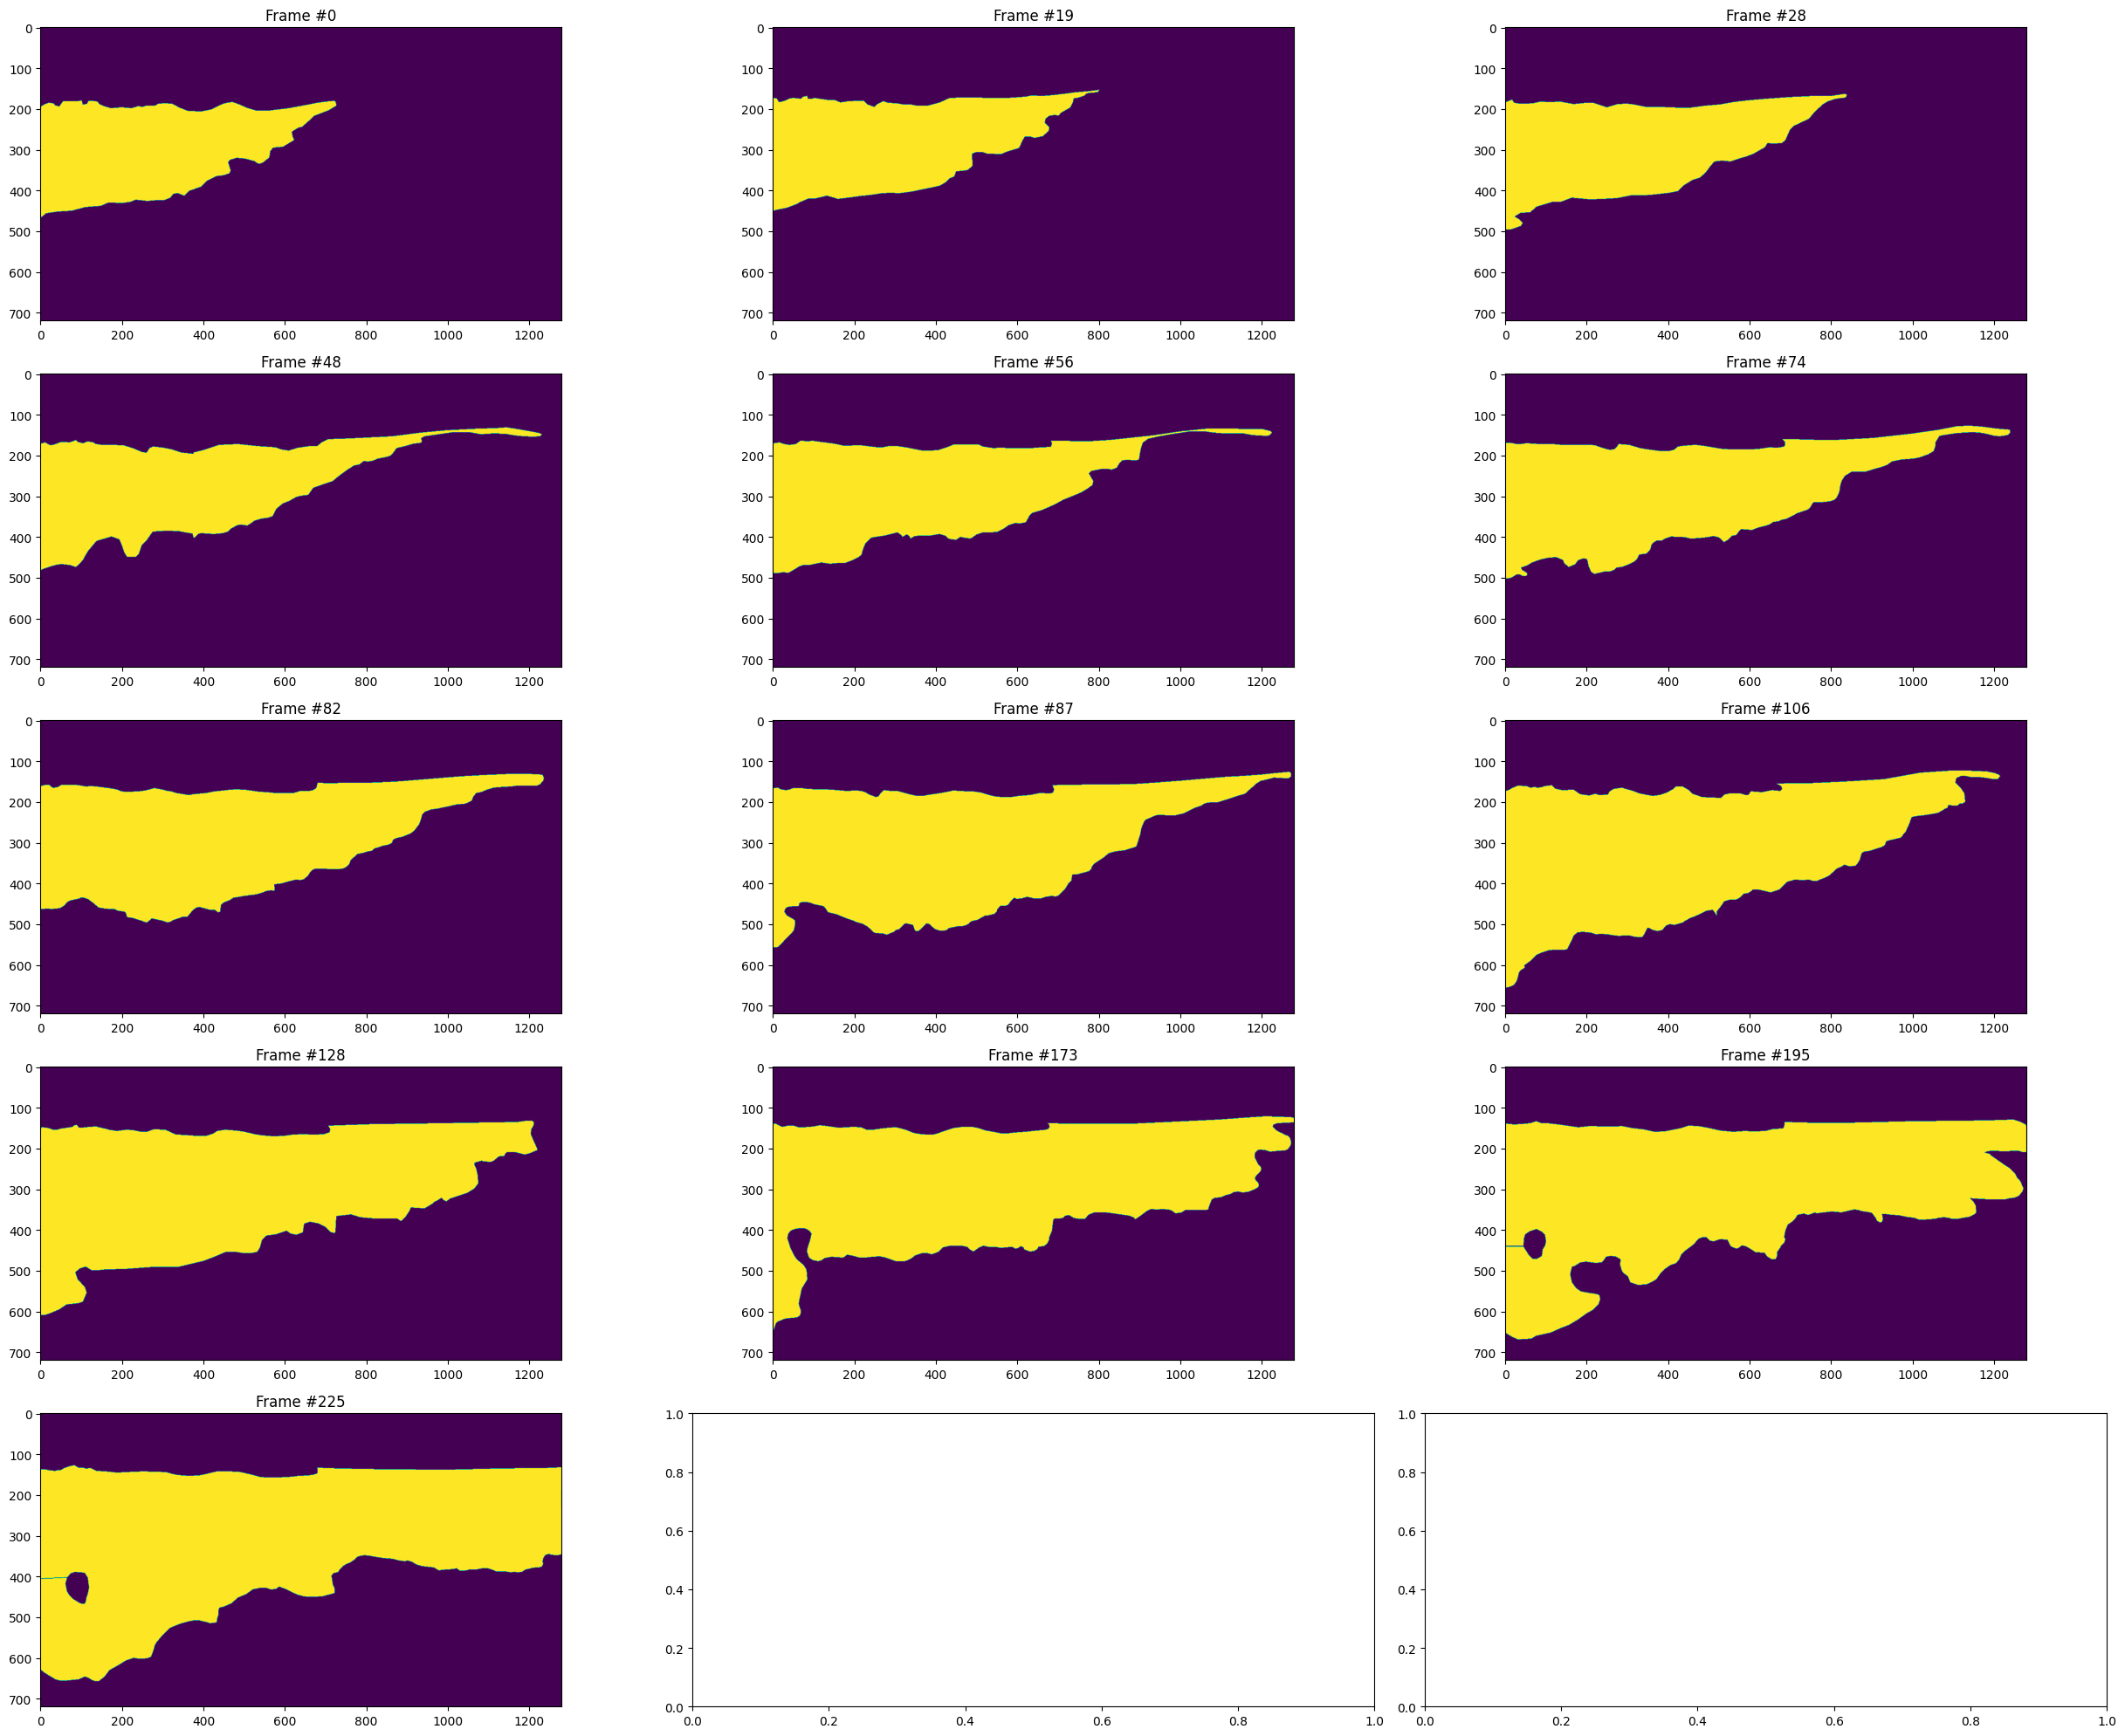

In [57]:
import rasterio
plot_polygons_as_images(distances=samples, polygons=sh_polygons)

In [153]:
# save the sampled polygons and their indices to a csv file
for i in samples["index"]:
    with open(SAMPLED_SEGS, "a") as f:
        f.write(str(i) +','+  sh_polygons[i].wkt + "\n")

In [59]:
# save the sampled polygons to a WKV file
with open(SAMPLED_SEGS_WKT, "w") as f:
    for i in samples["index"]:
        f.write(sh_polygons[i].wkt + "\n")